In [1]:
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
#os.environ['ARROW_PRE_0_15_IPC_FORMAT'] = '1'
from pyspark import SparkContext, SparkConf
from pyspark.pandas import read_csv
import pyspark.pandas as ps

In [2]:
sc = SparkContext.getOrCreate()
sc.setCheckpointDir('/alscp')
sc.getConf().getAll()
# means is for items, df is for collab
ps.set_option('compute.default_index_type', 'distributed')
path ='data/item/means.csv'

In [3]:
df = read_csv(path)

In [4]:
df.head()

,streamerId,avgInteractionTime,interactionCounts
0,2987163,3.338468,71
1,2751748,2.243566,34
2,3048233,2.031250,21
3,3051309,1.709515,1093
4,1950,1.000000,1


In [5]:
from pyspark.ml.feature import VectorAssembler
spark_df =df.to_spark() 

In [6]:
assemble=VectorAssembler(inputCols=[
'avgInteractionTime', 'interactionCounts'], outputCol='features')
assembled_data=assemble.transform(spark_df)

In [7]:
assembled_data.show(3)

+----------+------------------+-----------------+--------------------+
|streamerId|avgInteractionTime|interactionCounts|            features|
+----------+------------------+-----------------+--------------------+
|   2987163| 3.338468309859155|               71|[3.33846830985915...|
|   2751748|2.2435661764705883|               34|[2.24356617647058...|
|   3048233|           2.03125|               21|      [2.03125,21.0]|
+----------+------------------+-----------------+--------------------+
only showing top 3 rows



In [8]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [9]:
import numpy as np
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
cost = []
for k in range(2,15):
    print(k)
    kmeans = KMeans().setK(k).setSeed(38).setFeaturesCol("features")
    model = kmeans.fit(data_scale_output.select('streamerId', 'features').sample(False,0.1, seed=38))
    predictions = model.transform(data_scale_output)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    cost.append(silhouette)

2
Silhouette with squared euclidean distance = 0.999364497866511
3
Silhouette with squared euclidean distance = 0.9959383916275235
4
Silhouette with squared euclidean distance = 0.9962134409841853
5
Silhouette with squared euclidean distance = 0.9952402756959156
6
Silhouette with squared euclidean distance = 0.9892085265877981
7
Silhouette with squared euclidean distance = 0.9892615567140653
8
Silhouette with squared euclidean distance = 0.9892305018294876
9
Silhouette with squared euclidean distance = 0.9871092278870074
10
Silhouette with squared euclidean distance = 0.9716866639855457
11
Silhouette with squared euclidean distance = 0.9578553211992997
12
Silhouette with squared euclidean distance = 0.9184192059600309
13
Silhouette with squared euclidean distance = 0.9132974344095116
14
Silhouette with squared euclidean distance = 0.9085563512128815


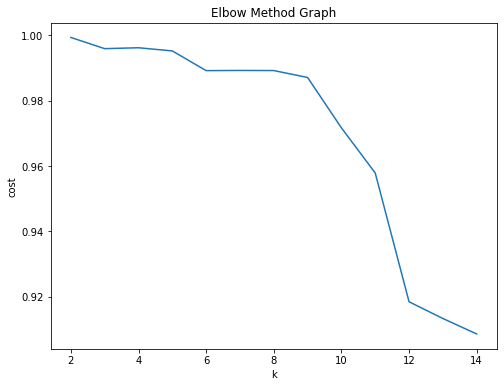

In [10]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.set_title('Elbow Method Graph')
ax.plot(range(2,15),cost)

In [11]:
kmeans = KMeans().setK(9).setSeed(38).setFeaturesCol("features") # use elbow silhouette value
model = kmeans.fit(data_scale_output.select('streamerId', 'features'))
predictions = model.transform(data_scale_output)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance for k = {7}: " + str(silhouette))

Silhouette with squared euclidean distance for k = 7: 0.9830464047789736


In [12]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[2.74042171 5.82940959]
[2.6126197e+00 4.2640000e+04]
[3.54289647e+00 3.56205556e+03]
[3.28779769e+00 1.31603333e+04]
[3.44739713e+00 6.62713514e+03]
[   3.33713562 1775.05050505]
[2.79294734e+00 2.73620000e+04]
[  3.18987411 230.62720403]
[  3.12847051 759.94425676]


In [13]:
predictions.show(10, False)

+----------+------------------+-----------------+---------------------------+------------------------------------------+----------+
|streamerId|avgInteractionTime|interactionCounts|features                   |standardized                              |prediction|
+----------+------------------+-----------------+---------------------------+------------------------------------------+----------+
|2987163   |3.338468309859155 |71               |[3.338468309859155,71.0]   |[1.290674693967263,0.28240187874208855]   |0         |
|2751748   |2.2435661764705883|34               |[2.2435661764705883,34.0]  |[0.867378036706194,0.13523470249621142]   |0         |
|3048233   |2.03125           |21               |[2.03125,21.0]             |[0.785295149987992,0.08352731624766]      |0         |
|3051309   |1.7095150960658738|1093             |[1.7095150960658738,1093.0]|[0.6609102344722644,4.347397936128209]    |8         |
|1950      |1.0               |1                |[1.0,1.0]                  

In [14]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
predictions = predictions.withColumn("xs", vector_to_array("standardized"))
predictions_pandas = predictions.to_pandas_on_spark()

In [15]:
predictions_pandas['prediction'].value_counts()

0    159370
7      2351
8       582
5       200
2        70
4        37
3        12
1         2
6         1
Name: prediction, dtype: int64

In [16]:
temp = ps.DataFrame(predictions_pandas['xs'].to_list(), columns=['avgInteractionTimeScaled','interactionCountsScaled'])

In [17]:
temp.head()

,avgInteractionTimeScaled,interactionCountsScaled
0,1.290675,0.282402
1,0.867378,0.135235
2,0.785295,0.083527
3,0.660910,4.347398
4,0.386607,0.003977


In [18]:
final = predictions_pandas.join(temp, how='outer')

In [19]:
final= final.drop(columns=['features','standardized','xs'])

In [20]:
final.head()

,streamerId,avgInteractionTime,interactionCounts,prediction,avgInteractionTimeScaled,interactionCountsScaled
0,2987163,3.338468,71,0,1.290675,0.282402
7,3040638,3.506663,469,7,1.355700,1.865443
19,3050662,5.468750,63,0,2.114256,0.250582
22,3027657,2.075948,323,7,0.802576,1.284730
25,17971,20.078125,6,0,7.762341,0.023865


In [21]:
final.to_spark().coalesce(1).write.format('csv').mode("overwrite").option('header', 'true').save('data/item_predictions')

In [22]:
model.write().overwrite().save('models/kmeans')

In [23]:
from pyspark.ml.clustering import KMeansModel
model2 = KMeansModel.load('models/kmeans')